Lo prmiero que hay que ahcer, creamos dos pipelines, en las dos cargamos el csv, en una pasamos las columna de varaibles categoricas a ordinalidad, en la otra hacemos un one hot encoding. (El one hto encodigin es malillo porque perdemos la informacion de de cual es mas caliente o frio y la distantcion entre la que estas, mejor es usar la ordinalidad).Luego en ambas hacemos un Pca, hay que hacer pca con parametros de 95% de la varianza de los datos. Y ya despues clustering.

## Random seed tiene que ser igual a un NIA 

In [13]:
import random
import numpy as np

nia = 100451958

# Establece la semilla para el generador de números aleatorios de Python
random.seed(nia)

# También puedes establecer la semilla para NumPy
np.random.seed(nia)

## Programar K-MEANS

La primera parte consiste en crear nuestro propio método K-means, para lo cual debemos implementar varios submétodos clave: inicialización de centroides (por qué es importante), asignación de clusters (por qué se necesita), actualización de centroides (por qué es esencial) y, por último, el método K-means en sí mismo (por qué lo usamos). Para evaluar la eficiencia de nuestro modelo en comparación con el K-means original, utilizaremos el método make_blobs para crear un ejemplo básico con el que se pueda asociar clusters. Posteriormente, usaremos métricas de tiempo y el "silhouette score" para comparar resultados.

Algunos problemas que hemos encontrado son los siguientes: al usar un valor de cluster_std = 1.0, que es una estandarización fuerte, la precisión del resultado puede depender en gran medida de cómo se inicialicen los centroides. Por ello, en ocasiones, la primera ejecución no funcionaba correctamente según lo planteado por sklearn. Para abordar este problema, hemos añadido a nuestro método de inicialización de centroides la estrategia K-means++ (y explicamos por qué), lo que ha mejorado significativamente el rendimiento de nuestro algoritmo K-means.

Comparación entre k-means personalizado y scikit-learn:
Tiempo de ejecución (personalizado): 0.0019996166229248047 segundos
Silhouette score (personalizado): 0.7915830011443039
Tiempo de ejecución (scikit-learn): 0.002997875213623047 segundos
Silhouette score (scikit-learn): 0.7915830011443039


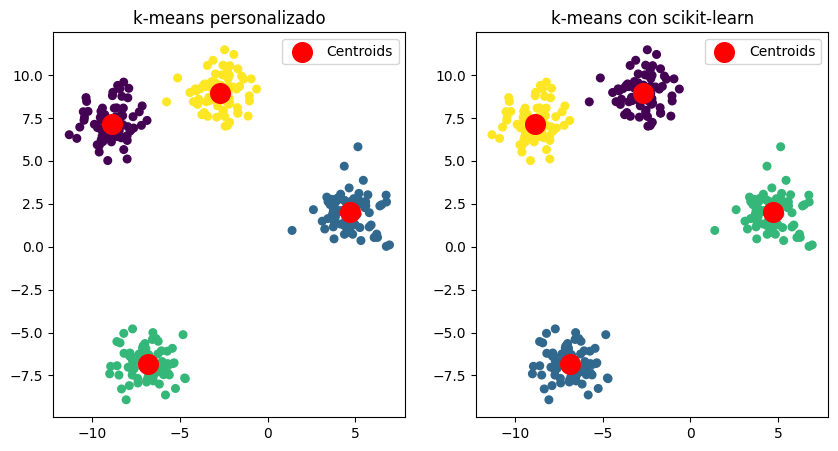

In [14]:
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import time

# Crear datos de ejemplo
num_samples = 300
num_features = 2
num_clusters = 4

data, _ = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=1.0, random_state=42)

# Elegir centros iniciales aleatorios
def initialize_centroids(data, k):
    # Escoger el primer centroide al azar
    centroids = [data[random.randint(0, len(data) - 1)]]

    # Escoger el resto de los centroides usando el método K-Means++
    for _ in range(1, k):
        distances = np.min(np.linalg.norm(data[:, np.newaxis] - np.array(centroids), axis=2), axis=1)
        probabilities = distances / distances.sum()
        new_centroid_index = np.random.choice(range(len(data)), p=probabilities)
        centroids.append(data[new_centroid_index])

    return np.array(centroids)

# Asignar puntos a los clústeres
def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# Actualizar los centros de los clústeres
def update_centroids(data, labels, k):
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

# Función para el algoritmo k-means
def kmeans(data, k, num_iterations=10000, tolerance=1e-4):

    centroids = initialize_centroids(data, k)

    for _ in range(num_iterations):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)

        # Chequeo de convergencia
        if np.linalg.norm(centroids - new_centroids) < tolerance:
            break

        centroids = new_centroids

    return centroids, labels


#Comparación entre k-means personalizado y scikit-learn
start_time = time.time()
centroids_custom, labels_custom = kmeans(data, num_clusters)
custom_time = time.time() - start_time
silhouette_custom = silhouette_score(data, labels_custom)

start_time = time.time()
sklearn_kmeans = SKLearnKMeans(n_clusters=num_clusters, random_state=42).fit(data)
labels_sklearn = sklearn_kmeans.labels_
centroids_sklearn = sklearn_kmeans.cluster_centers_
sklearn_time = time.time() - start_time
silhouette_sklearn = silhouette_score(data, labels_sklearn)

# Mostrar resultados
print("Comparación entre k-means personalizado y scikit-learn:")
print("Tiempo de ejecución (personalizado):", custom_time, "segundos")
print("Silhouette score (personalizado):", silhouette_custom)

print("Tiempo de ejecución (scikit-learn):", sklearn_time, "segundos")
print("Silhouette score (scikit-learn):", silhouette_sklearn)

# Visualizar resultados
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("k-means personalizado")
plt.scatter(data[:, 0], data[:, 1], c=labels_custom, cmap='viridis', s=30)
plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], c='red', s=200, label='Centroids')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("k-means con scikit-learn")
plt.scatter(data[:, 0], data[:, 1], c=labels_sklearn, cmap='viridis', s=30)
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], c='red', s=200, label='Centroids')
plt.legend()


plt.show()

# Preprocesado

Primero cargamos el archivo CSV y realizamos los ajustes necesarios. Como primer paso, visualizamos los datos para identificar las variables categóricas y examinamos sus valores para entender mejor su contenido y estructura.

In [15]:
# Importar las librerías necesarias
import pandas as pd

df = pd.read_csv("Stars2.csv")
unique_colors = df['Color'].unique()
unique_spectral_classes = df['Spectral_Class'].unique()

print("Clases únicas para 'color':", unique_colors)
print("Clases únicas para 'Spectral_class':", unique_spectral_classes)

# Visualizar
df.head()


Clases únicas para 'color': ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']
Clases únicas para 'Spectral_class': ['M' 'B' 'A' 'F' 'O' 'K' 'G']


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


Una vez visto que colo no tiene buenos colores o lagunos son los mimso pero con distinto nombres pues le aplicamos un color mappin para restrucutrar los datos, a su vez vemos los datos faltantes al mas puro prepocesado basico

In [16]:
color_mapping = {
    "Blue White": "Blue-White",
    "Blue white": "Blue-White",
    "Blue-white": "Blue-White",
    "White-Yellow": "White-Yellow",
    "yellow-white": "White-Yellow",
    "yellowish": "Yellowish",
	"white": "White",
}

# Aplicar el mapeo a la columna de color
df["Color"] = df["Color"].replace(color_mapping)

# Obtener las nuevas clases únicas para verificar la fusión
unique_colors = df["Color"].unique()
print("Clases únicas después de fusionar similares:", unique_colors)

Clases únicas después de fusionar similares: ['Red' 'Blue-White' 'White' 'Yellowish White' 'Pale yellow orange' 'Blue'
 'Whitish' 'White-Yellow' 'Orange' 'Yellowish' 'Orange-Red']


Tambien confirmamos que todos los datos se ven correctamente

In [17]:
print("Número de instancias y características:")
print(df.shape)
print("Valores faltantes:")
print(df.isnull().sum())
constantes = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas constantes:")
print(constantes)

Número de instancias y características:
(240, 6)
Valores faltantes:
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64
Columnas constantes:
[]


## DataFrames con las cuatro combinaciones posibles para transformar columnas categóricas

Vamos a crear diferentes DataFrames con las cuatro combinaciones posibles para transformar columnas categóricas. Para ello, diseñaremos pipelines distintas que permitan convertir cada grupo de columnas categóricas, ya sea utilizando codificación ordinal o one-hot encoding. Esto nos dará flexibilidad para experimentar con distintas formas de procesar las variables categóricas y evaluar su impacto.

In [18]:
from sklearn.preprocessing import OrdinalEncoder

# Definir el orden para el OrdinalEncoder
color_order = ["Red", "Orange-Red", "Orange", "Pale yellow orange", 
               "Yellowish", "Yellowish White", "White", 
               "Whitish", "White-Yellow", "Blue-White", "Blue"]

spectral_class_order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Crear un OrdinalEncoder con orden específico
ordinal_encoder = OrdinalEncoder(categories=[color_order, spectral_class_order])

# Aplicar OrdinalEncoder a las columnas categóricas
df_ordinal = df.copy()
df_ordinal[['Color', 'Spectral_Class']] = ordinal_encoder.fit_transform(df[['Color', 'Spectral_Class']])

# Mostrar el DataFrame con valores ordinales
print("DataFrame con columnas categóricas convertidas a ordinalidad:")
df_ordinal.head()


DataFrame con columnas categóricas convertidas a ordinalidad:


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0.0,6.0
1,3042,0.000500,0.1542,16.60,0.0,6.0
2,2600,0.000300,0.1020,18.70,0.0,6.0
3,2800,0.000200,0.1600,16.65,0.0,6.0
4,1939,0.000138,0.1030,20.06,0.0,6.0


In [19]:
# Crear el dataframe con One-Hot Encoding
df_one_hot = pd.get_dummies(df.copy(), columns=['Color', 'Spectral_Class'])

# Convertir las columnas booleanas a valores 0 y 1
df_one_hot = df_one_hot.astype(int)

print("DataFrame con One-Hot Encoding usando 0 y 1:")
df_one_hot.head()



DataFrame con One-Hot Encoding usando 0 y 1:


,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale yellow orange,Color_Red,...,Color_Whitish,Color_Yellowish,Color_Yellowish White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,3042,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2600,0,0,18,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2800,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1939,0,0,20,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [20]:
# Ordinalidad para "color"
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[color_order])

df_oc_ohes = df.copy()
df_oc_ohes['Color'] = ordinal_encoder.fit_transform(df[['Color']])

# One-Hot Encoding para "Spectral_class"
df_oc_ohes = pd.get_dummies(df_oc_ohes, columns=['Spectral_Class'])

# Convertir booleanos a ceros y unos
df_mixed_1 = df_oc_ohes.astype(int)

print("DataFrame con 'Color' en ordinalidad y 'Spectral_Class' en One-Hot Encoding:")
df_mixed_1.head()



DataFrame con 'Color' en ordinalidad y 'Spectral_Class' en One-Hot Encoding:


,Temperature,L,R,A_M,Color,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0.002400,0.1700,16.12,0.0,False,False,False,False,False,True,False
1,3042,0.000500,0.1542,16.60,0.0,False,False,False,False,False,True,False
2,2600,0.000300,0.1020,18.70,0.0,False,False,False,False,False,True,False
3,2800,0.000200,0.1600,16.65,0.0,False,False,False,False,False,True,False
4,1939,0.000138,0.1030,20.06,0.0,False,False,False,False,False,True,False


In [21]:
# One-Hot Encoding para "color"
df_ohec_os = pd.get_dummies(df, columns=['Color'])

ordinal_encoder = OrdinalEncoder(categories=[spectral_class_order])
# Ordinalidad para "Spectral_class"
df_ohec_os['Spectral_Class'] = ordinal_encoder.fit_transform(df[['Spectral_Class']])

# Convertir booleanos a ceros y unos
df_mixed_2 = df_ohec_os.astype(int)

print("DataFrame con 'Color' en One-Hot Encoding y 'Spectral_Class' en ordinalidad:")
df_mixed_2.head()


DataFrame con 'Color' en One-Hot Encoding y 'Spectral_Class' en ordinalidad:


,Temperature,L,R,A_M,Spectral_Class,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale yellow orange,Color_Red,Color_White,Color_White-Yellow,Color_Whitish,Color_Yellowish,Color_Yellowish White
0,3068,0,0,16,6,0,0,0,0,0,1,0,0,0,0,0
1,3042,0,0,16,6,0,0,0,0,0,1,0,0,0,0,0
2,2600,0,0,18,6,0,0,0,0,0,1,0,0,0,0,0
3,2800,0,0,16,6,0,0,0,0,0,1,0,0,0,0,0
4,1939,0,0,20,6,0,0,0,0,0,1,0,0,0,0,0


## PCA


Después de crear los cuatro DataFrames con todas sus variaciones, aplicamos el Análisis de Componentes Principales (PCA). Este proceso nos ayuda a visualizar los datos de manera más clara, ya que reduce las dimensiones a solo dos columnas, que son combinaciones lineales de todas las columnas originales. Esto simplifica la visualización y el análisis, permitiéndonos entender mejor las estructuras subyacentes y las relaciones entre variables

In [22]:
import pandas as pd
from sklearn.decomposition import PCA

# Aplicar PCA con 2 componentes
pca = PCA(n_components=2)

# Aplicar PCA al primer DataFrame (color en ordinalidad, Spectral_class en One-Hot Encoding)
df_mixed_1_pca = pca.fit_transform(df_mixed_1)

# Convertir el resultado a DataFrame para visualización
df_mixed_1_pca_df = pd.DataFrame(df_mixed_1_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el primer DataFrame:")
print(df_mixed_1_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_mixed_2_pca = pca.fit_transform(df_mixed_2)

# Convertir el resultado a DataFrame para visualización
df_mixed_2_pca_df = pd.DataFrame(df_mixed_2_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el segundo DataFrame:")
print(df_mixed_2_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_ordinal_pca = pca.fit_transform(df_ordinal)

# Convertir el resultado a DataFrame para visualización
df_ordinal_pca_df = pd.DataFrame(df_ordinal_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el tercer DataFrame:")
print(df_ordinal_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_one_hot_pca = pca.fit_transform(df_one_hot)

# Convertir el resultado a DataFrame para visualización
df_one_hot_pca_df = pd.DataFrame(df_one_hot_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el cuarto DataFrame:")
print(df_one_hot_pca_df.head())


Resultados de PCA para el primer DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.895126     -5177.123364
1   -107321.440846     -5203.116539
2   -107330.718158     -5645.000863
3   -107326.520237     -5445.053008
4   -107344.592110     -6305.827695
Resultados de PCA para el segundo DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.895108     -5177.122572
1   -107321.440827     -5203.115748
2   -107330.718139     -5645.000095
3   -107326.520218     -5445.052229
4   -107344.592091     -6305.826960
Resultados de PCA para el tercer DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.921035     -5177.122876
1   -107321.468698     -5203.115957
2   -107330.746298     -5644.999839
3   -107326.548382     -5445.052483
4   -107344.620387     -6305.826578
Resultados de PCA para el cuarto DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.895097     -5177.122282
1   -107321.440817     -5203.115458
2   -107330.718129     -5644.999815
3   -107326.520207     -5445.05

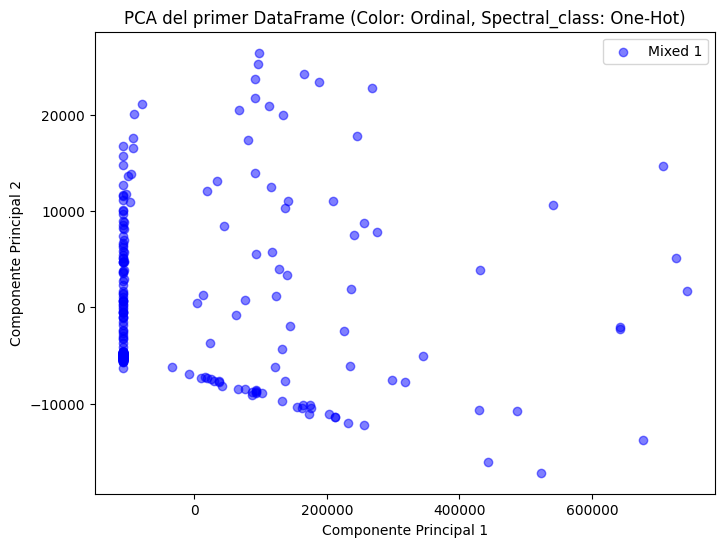

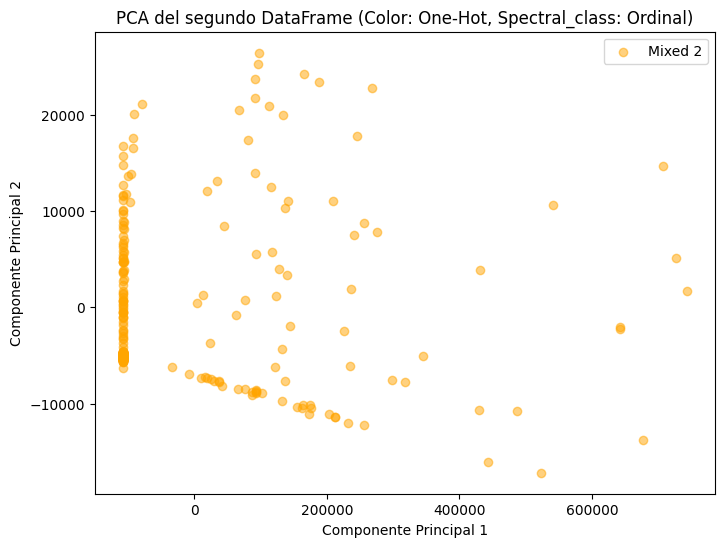

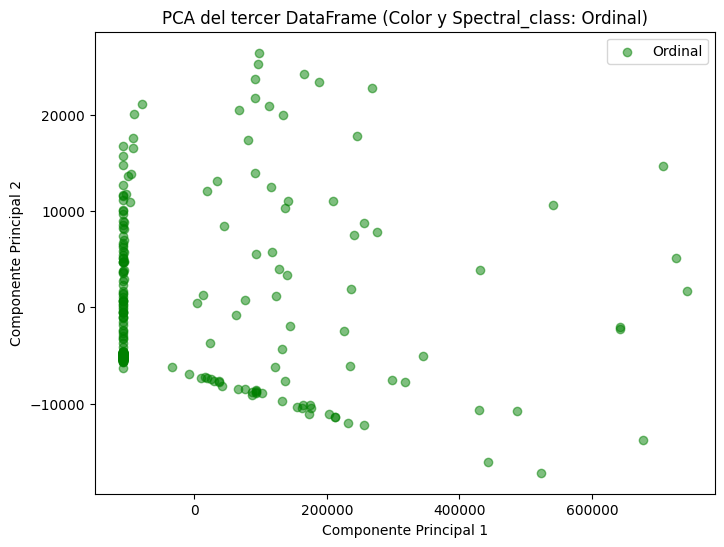

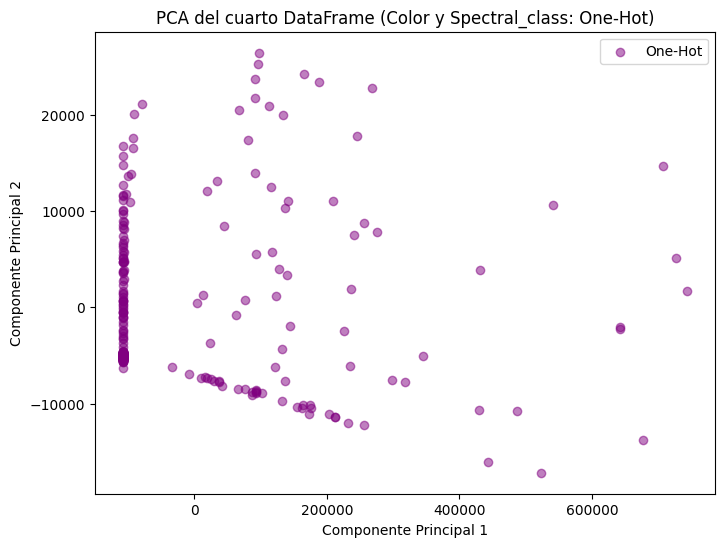

In [23]:
import matplotlib.pyplot as plt

# Gráfico para el primer DataFrame (color en ordinalidad, Spectral_class en One-Hot Encoding)
plt.figure(figsize=(8, 6))
plt.scatter(df_mixed_1_pca_df["PCA_Component_1"], df_mixed_1_pca_df["PCA_Component_2"], c='blue', alpha=0.5, label='Mixed 1')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del primer DataFrame (Color: Ordinal, Spectral_class: One-Hot)")
plt.legend()
plt.show()

# Gráfico para el segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
plt.figure(figsize=(8, 6))
plt.scatter(df_mixed_2_pca_df["PCA_Component_1"], df_mixed_2_pca_df["PCA_Component_2"], c='orange', alpha=0.5, label='Mixed 2')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del segundo DataFrame (Color: One-Hot, Spectral_class: Ordinal)")
plt.legend()
plt.show()

# Gráfico para el tercer DataFrame (color y Spectral_class en ordinalidad)
plt.figure(figsize=(8, 6))
plt.scatter(df_ordinal_pca_df["PCA_Component_1"], df_ordinal_pca_df["PCA_Component_2"], c='green', alpha=0.5, label='Ordinal')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del tercer DataFrame (Color y Spectral_class: Ordinal)")
plt.legend()
plt.show()

# Gráfico para el cuarto DataFrame (color y Spectral_class en One-Hot Encoding)
plt.figure(figsize=(8, 6))
plt.scatter(df_one_hot_pca_df["PCA_Component_1"], df_one_hot_pca_df["PCA_Component_2"], c='purple', alpha=0.5, label='One-Hot')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del cuarto DataFrame (Color y Spectral_class: One-Hot)")
plt.legend()
plt.show()


Una posible razón por la que las gráficas se parecen tanto podría ser que los parámetros de "color" y "spectral class" no tienen un impacto significativo en la varianza, por lo que su codificación no hace mucha diferencia. Sin embargo, para tener más certeza, vamos a escalar los datos para ver si eso arroja un resultado más claro.

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Crear el StandardScaler
scaler = StandardScaler()

# Escalar los DataFrames
df_mixed_1_scaled = scaler.fit_transform(df_mixed_1)
df_mixed_2_scaled = scaler.fit_transform(df_mixed_2)
df_ordinal_scaled = scaler.fit_transform(df_ordinal)
df_one_hot_scaled = scaler.fit_transform(df_one_hot)

pca = PCA(n_components=2) 

df_mixed_1_pca = pca.fit_transform(df_mixed_1_scaled)
df_mixed_2_pca = pca.fit_transform(df_mixed_2_scaled)
df_ordinal_pca = pca.fit_transform(df_ordinal_scaled)
df_one_hot_pca = pca.fit_transform(df_one_hot_scaled)

# Crear DataFrames para almacenar los resultados del PCA
df_mixed_1_pca_df = pd.DataFrame(df_mixed_1_pca, columns=["PCA_Component_1", "PCA_Component_2"])
df_mixed_2_pca_df = pd.DataFrame(df_mixed_2_pca, columns=["PCA_Component_1", "PCA_Component_2"])
df_ordinal_pca_df = pd.DataFrame(df_ordinal_pca, columns=["PCA_Component_1", "PCA_Component_2"])
df_one_hot_pca_df = pd.DataFrame(df_one_hot_pca, columns=["PCA_Component_1", "PCA_Component_2"])

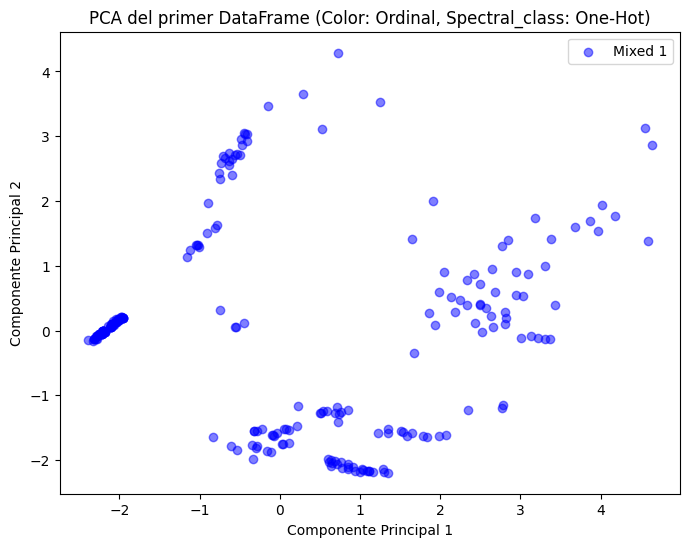

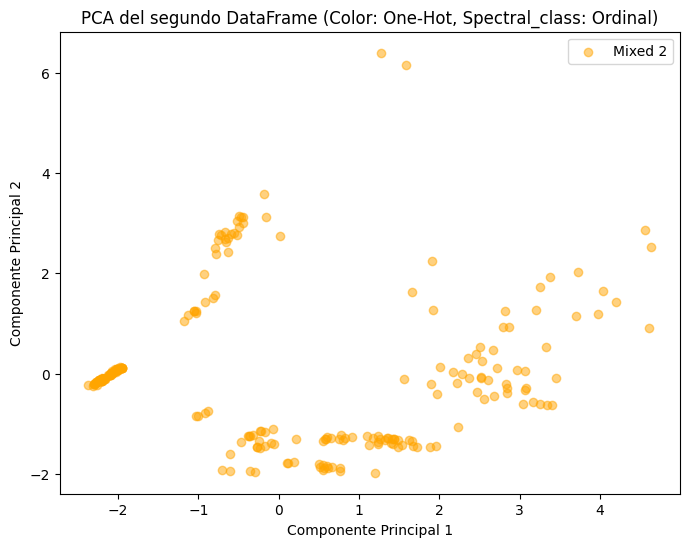

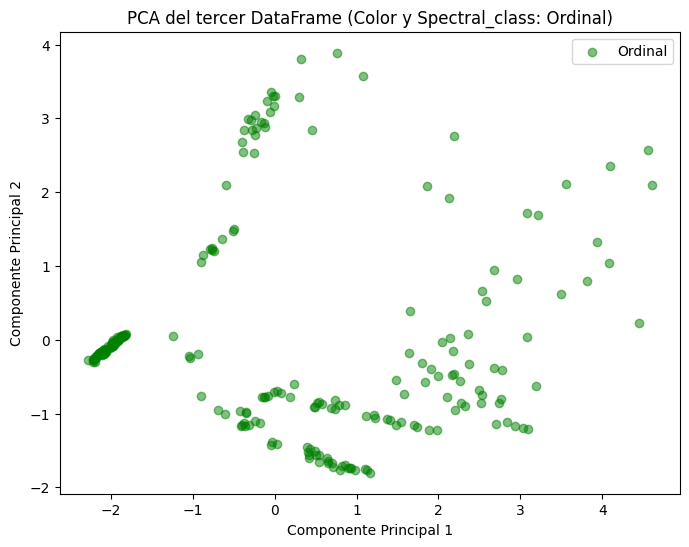

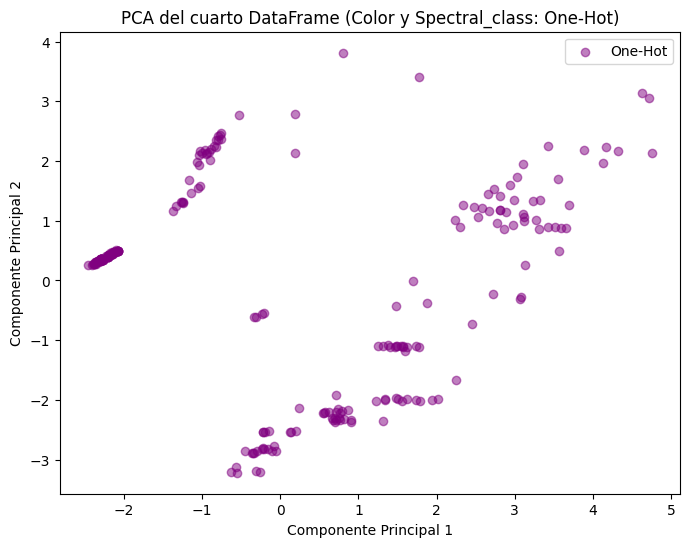

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(df_mixed_1_pca_df["PCA_Component_1"], df_mixed_1_pca_df["PCA_Component_2"], c='blue', alpha=0.5, label='Mixed 1')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del primer DataFrame (Color: Ordinal, Spectral_class: One-Hot)")
plt.legend()
plt.show()

# Gráfico para el segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
plt.figure(figsize=(8, 6))
plt.scatter(df_mixed_2_pca_df["PCA_Component_1"], df_mixed_2_pca_df["PCA_Component_2"], c='orange', alpha=0.5, label='Mixed 2')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del segundo DataFrame (Color: One-Hot, Spectral_class: Ordinal)")
plt.legend()
plt.show()

# Gráfico para el tercer DataFrame (color y Spectral_class en ordinalidad)
plt.figure(figsize=(8, 6))
plt.scatter(df_ordinal_pca_df["PCA_Component_1"], df_ordinal_pca_df["PCA_Component_2"], c='green', alpha=0.5, label='Ordinal')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del tercer DataFrame (Color y Spectral_class: Ordinal)")
plt.legend()
plt.show()

# Gráfico para el cuarto DataFrame (color y Spectral_class en One-Hot Encoding)
plt.figure(figsize=(8, 6))
plt.scatter(df_one_hot_pca_df["PCA_Component_1"], df_one_hot_pca_df["PCA_Component_2"], c='purple', alpha=0.5, label='One-Hot')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del cuarto DataFrame (Color y Spectral_class: One-Hot)")
plt.legend()
plt.show()

Ahora parece que tiene mas sentido vamos a continuar con estos datos

## Aplicar Algortimo de CLustering

Ahora le vamos a aplicar algoritmo de DBSCAN y K-MEANS pero antes debemos determinar cuantos clusters queremos aplicarle para eso aplicaremos el metodo del codo (Elbow Method):

La idea es obtener para valor de K la suma de los cuadrados de la distancia de cada punto con el centroide al que se encuentra asignado (se obtiene de `.inertia_`). Es una medida de lo coherentes que son internamente los clusters. La idea es que si K crece el valor de `.inertia_` es menor porque cada cluster es más pequeño. Sin embargo, a partir de cierto punto, la adición de más clusters proporciona rendimientos decrecientes en términos de reducción de `.inertia_`, y la tasa de disminución se ralentiza, formando un codo en el gráfico. Ese sería el valor óptimo para seleccionar.

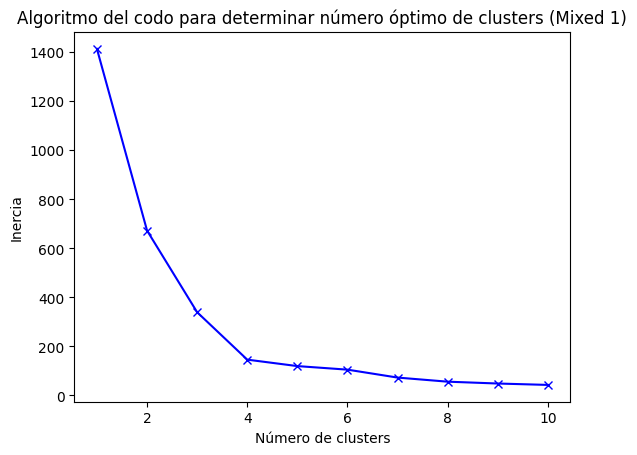

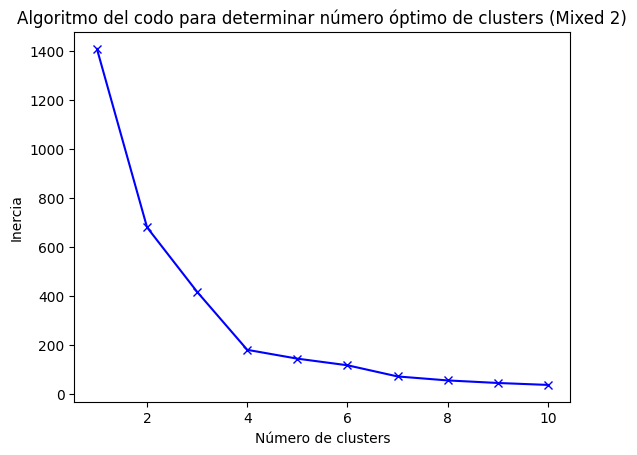

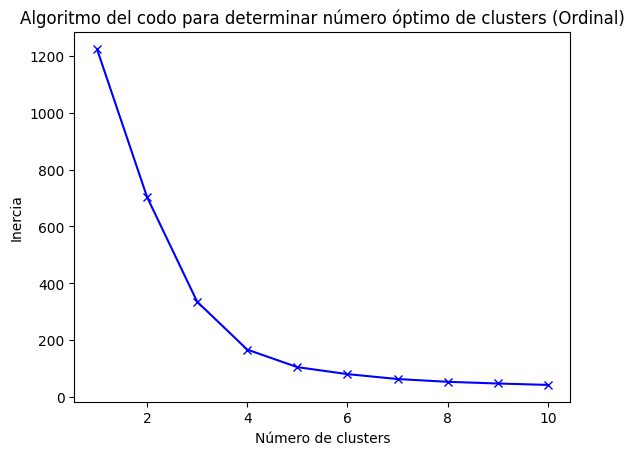

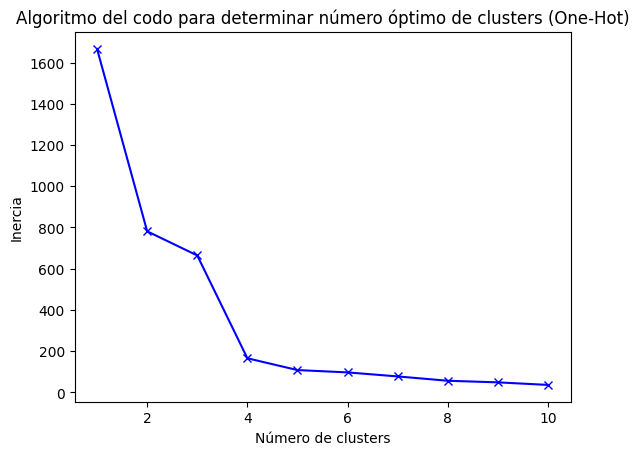

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Algoritmo del codo para el primer DataFrame
inertias = []
k_range = range(1, 11)  # Analiza el rango de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_mixed_1_pca_df[['PCA_Component_1', 'PCA_Component_2']])
    inertias.append(kmeans.inertia_)

# Gráfico del algoritmo del codo
plt.figure()
plt.plot(k_range, inertias, 'bx-')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Algoritmo del codo para determinar número óptimo de clusters (Mixed 1)")
plt.show()

# Repetir para los otros DataFrames
dataframes = [df_mixed_2_pca_df, df_ordinal_pca_df, df_one_hot_pca_df]
titles = ["Mixed 2", "Ordinal", "One-Hot"]

for df, title in zip(dataframes, titles):
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df[['PCA_Component_1', 'PCA_Component_2']])
        inertias.append(kmeans.inertia_)

    plt.figure()
    plt.plot(k_range, inertias, 'bx-')
    plt.xlabel("Número de clusters")
    plt.ylabel("Inercia")
    plt.title(f"Algoritmo del codo para determinar número óptimo de clusters ({title})")
    plt.show()


A pesar de que no es necesario calcular el metodo del codo para los 4 df que hemos generado y con uno valdria porque es mas o menos igual todo pero da igual. En este caso vemos que todos nos indican que el numero de clusters optimo es 4, eso es lo que le aplicaremos a k-means:

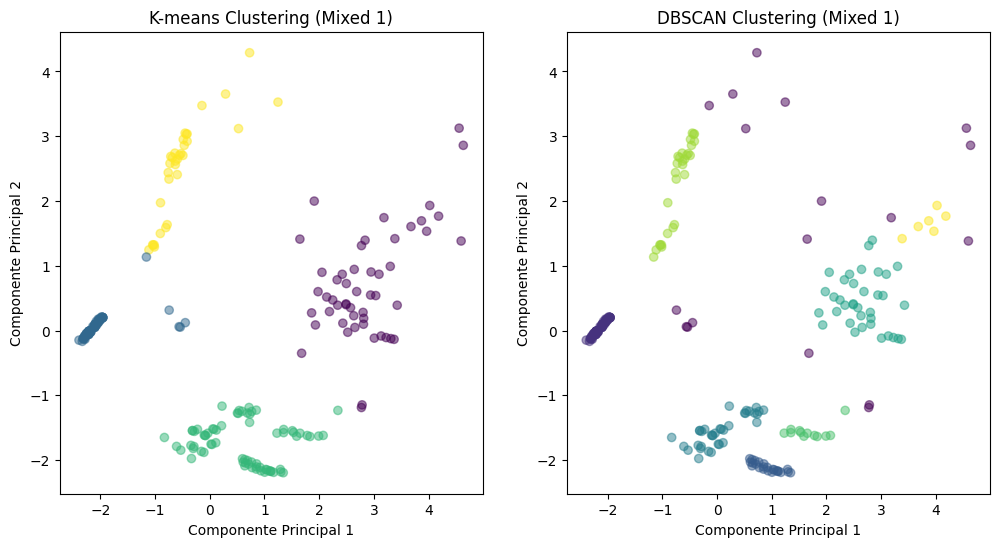

Silhouette Score para K-means (Mixed 1): 0.711
Silhouette Score para DBSCAN (Mixed 1): 0.702


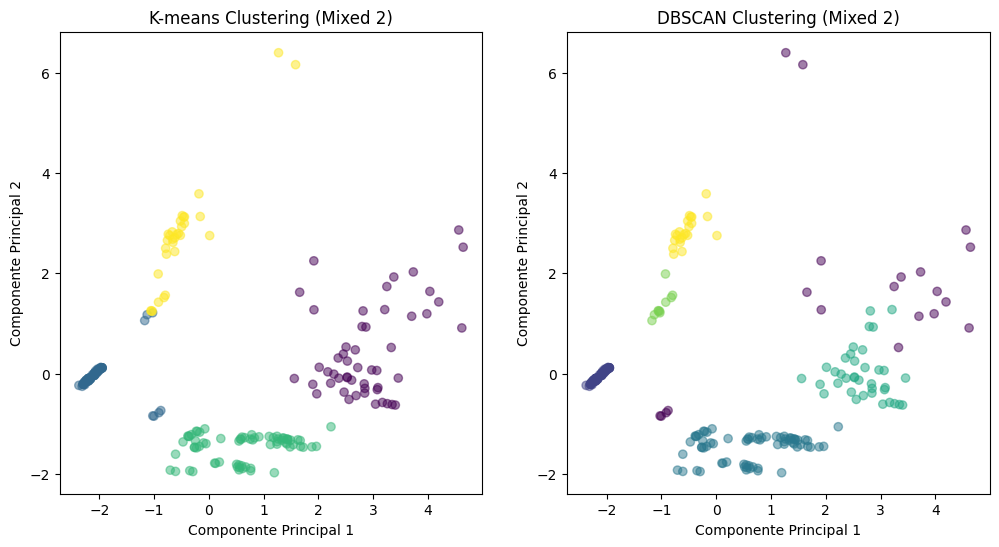

Silhouette Score para K-means (Mixed 2): 0.672
Silhouette Score para DBSCAN (Mixed 2): 0.728


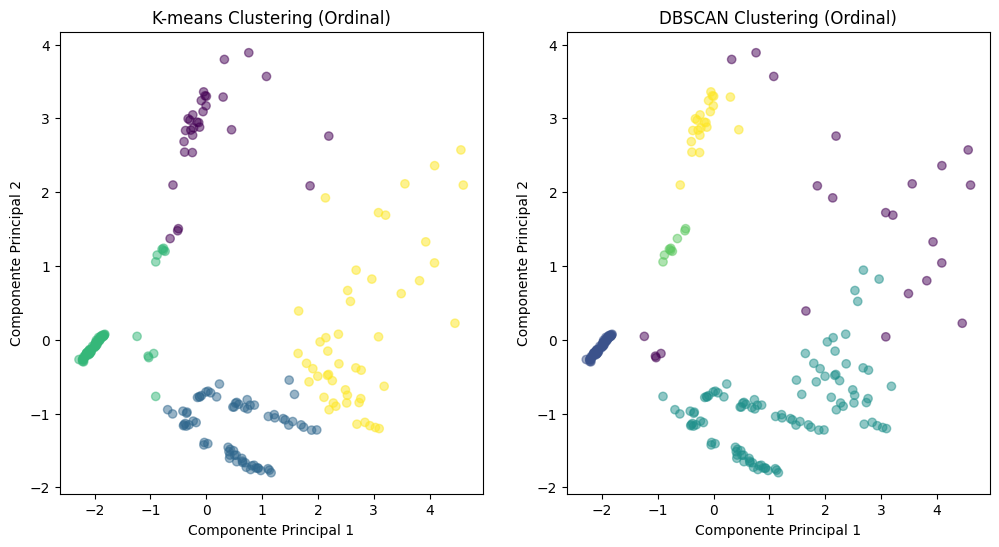

Silhouette Score para K-means (Ordinal): 0.633
Silhouette Score para DBSCAN (Ordinal): 0.674


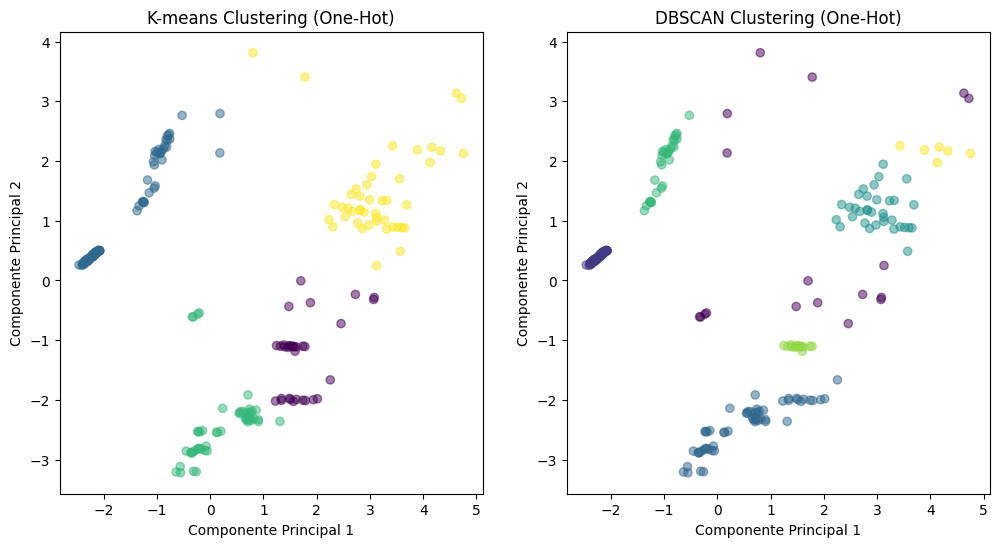

Silhouette Score para K-means (One-Hot): 0.639
Silhouette Score para DBSCAN (One-Hot): 0.681


In [33]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# DataFrames a procesar y sus respectivos títulos
dataframes = [df_mixed_1_pca_df, df_mixed_2_pca_df, df_ordinal_pca_df, df_one_hot_pca_df]
titles = ["Mixed 1", "Mixed 2", "Ordinal", "One-Hot"]

# Aplicar K-means, DBSCAN, y mostrar resultados en un solo bucle
for df, title in zip(dataframes, titles):
    # Aplicar K-means
    kmeans = KMeans(n_clusters=4, random_state=100451958)
    df['KMeans_Labels'] = kmeans.fit_predict(df[['PCA_Component_1', 'PCA_Component_2']])

    # Aplicar DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    df['DBSCAN_Labels'] = dbscan.fit_predict(df[['PCA_Component_1', 'PCA_Component_2']])

    # Gráficos para visualizar K-means y DBSCAN
    plt.figure(figsize=(12, 6))
    
    # Gráfico para K-means
    plt.subplot(1, 2, 1)
    plt.scatter(df['PCA_Component_1'], df['PCA_Component_2'], c=df['KMeans_Labels'], cmap='viridis', alpha=0.5)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title(f"K-means Clustering ({title})")
    
    # Gráfico para DBSCAN
    plt.subplot(1, 2, 2)
    plt.scatter(df['PCA_Component_1'], df['PCA_Component_2'], c=df['DBSCAN_Labels'], cmap='viridis', alpha=0.5)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title(f"DBSCAN Clustering ({title})")
    
    plt.show()

    # Calcular el Silhouette Score para K-means y DBSCAN
    kmeans_silhouette = silhouette_score(df[['PCA_Component_1', 'PCA_Component_2']], df['KMeans_Labels'])

    # Para DBSCAN, ignorar puntos con etiqueta -1 (ruido)
    dbscan_labels = df['DBSCAN_Labels']
    non_noise_indices = (dbscan_labels != -1)
    dbscan_silhouette = silhouette_score(
        df.loc[non_noise_indices, ['PCA_Component_1', 'PCA_Component_2']], dbscan_labels[non_noise_indices])

    print(f"Silhouette Score para K-means ({title}): {kmeans_silhouette:.3f}")
    print(f"Silhouette Score para DBSCAN ({title}): {dbscan_silhouette:.3f}")



El Silhouette Score indica qué tan bien están agrupados los datos dentro de sus respectivos clusters, y cuánto se distinguen de otros clusters. Los valores varían entre -1 y 1, donde un puntaje más alto sugiere una mejor separación entre clusters. Vamos a comentar los resultados de acuerdo con las combinaciones de codificación de datos:

Resultados para "Mixed 1"
K-means: Con un Silhouette Score de 0.711, el clustering parece estar bien definido, con una buena separación entre los clusters.
DBSCAN: El puntaje es 0.702, ligeramente inferior al de K-means, pero aún indica una buena agrupación.
En general, ambos algoritmos muestran un resultado sólido para esta configuración, con K-means apenas superando a DBSCAN.

Resultados para "Mixed 2"
K-means: El puntaje es de 0.672, sugiriendo que hay cierta superposición entre clusters, pero en general el agrupamiento es aceptable.
DBSCAN: Con un puntaje de 0.728, DBSCAN parece funcionar mejor para esta combinación, sugiriendo una mayor separación entre clusters.
En este caso, DBSCAN supera a K-means, posiblemente porque puede manejar mejor puntos atípicos o estructuras de datos más complejas.

Resultados para "Ordinal"
K-means: Con 0.633, este es el puntaje más bajo entre todos, indicando que los clusters están menos definidos.
DBSCAN: Con un Silhouette Score de 0.674, es ligeramente superior al de K-means, pero aún relativamente bajo.
Estos resultados sugieren que la codificación ordinal puede tener más dificultades para proporcionar una buena separación entre clusters.

Resultados para "One-Hot"
K-means: Con un puntaje de 0.639, la calidad del clustering es similar a la configuración "Ordinal".
DBSCAN: Con un Silhouette Score de 0.681, DBSCAN parece tener una ligera ventaja sobre K-means en esta configuración.
Estos resultados también sugieren que la codificación One-Hot ofrece una mejor separación para DBSCAN que para K-means.

Conclusión
Comparación general: DBSCAN parece tener un rendimiento superior o igual a K-means en todas las combinaciones, especialmente cuando se necesita detectar estructuras más complejas o manejar ruido.
Silhouette Score: Los resultados para cada configuración indican variabilidad en la calidad del clustering, pero en general, DBSCAN parece ofrecer mayor estabilidad y flexibilidad.
Dado que los Silhouette Scores son todos positivos y relativamente altos, esto sugiere que ambos algoritmos, en sus diferentes configuraciones, están generando agrupamientos válidos. Sin embargo, la superioridad de DBSCAN en algunas combinaciones podría indicar que este algoritmo es más adecuado para datos con estructuras no lineales o clusters de formas irregulares.

## Hay similitudes?

| Clase                     | Temperatura | L           | R             | A_M   | Color         | Clase Espectral |
|---------------------------|-------------|-------------|---------------|-------|---------------|-----------------|
| Enana roja                | 3.000       | 7,0∙10^-4   | 1,0∙10^-1     | +17.5 | rojo          | K-M             |
| Enana marrón              | 3.300       | 5,5∙10^-3   | 3,5∙10^-1     | +12.5 | rojo          | M               |
| Enana blanca              | 14.000      | 2,5∙10^-3   | 1,0∙10^-2     | +12.6 | blanca        | B-G             |
| Estrella en secuencia     | 16.000      | 3.2∙10^4    | 4,4           | -0.4  | blancaamarilla| B-M             |
| Super gigante             | 15.000      | 3.0∙10^5    | 5,0∙10^1      | -6.4  | blancaamarilla| B-M             |
| Hiper gigante             | 11.000      | 3.0∙10^5    | 1,4∙10^3      | -9.6  | amarilla      | B-M             |
